In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import rotation_matrix
#from methods import *

In [3]:
from models import Similitude, Similitude2, RobustSimilitude
dtype=torch.float32
model = RobustSimilitude(ncells=100,dtype=dtype,rectify=False,dropout=False,lr=1e-3,
                        p_magnitude=1e-1,r_magnitude=1e-1) 

In [4]:
if False:
    # Overwrite Initial Phase Placements
    start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
    #start_phases = torch.cat([torch.normal(torch.zeros((model.ncells//2,2)),0.01),torch.normal(torch.zeros((model.ncells//2,2))+0.2,0.01)])
    
    #model = torch.load('./saved-models/Similitude2-14-dirac')
    #start_phases = model.phases.detach().numpy()
    #start_phases = np.concatenate([start_phases,start_phases@rotation_matrix(10).T+0.2])
    #start_phases = np.concatenate([start_phases,start_phases+0.2])
    
    model.set_phases(start_phases)
start_phases = model.phases.detach().clone().numpy()

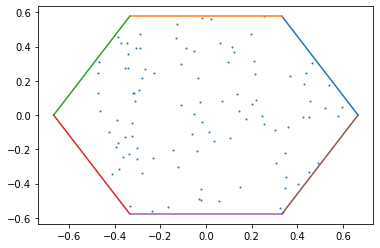

In [5]:
fig,ax=model.unit_cell.plot()
ax.scatter(*start_phases.T,s=1)

In [6]:
# Train model
nsamples_space = 2**10
loss_history = []
Gs = []
phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(4000):
    rs = model.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=dtype)
    loss = model.train_step(rs)
    G = np.mean(model.metric_tensor(model.jacobian(rs)).detach().numpy(),axis=0)
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
    Gs.append(G)
Gs = np.array(Gs)

100%|██████████████████████████████████████| 4000/4000 [00:19<00:00, 209.41it/s]


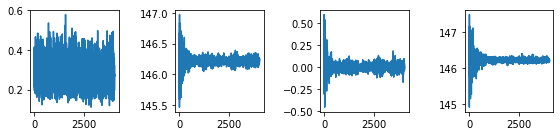

In [7]:
#plt.semilogy(loss_history)
fig,axs=plt.subplots(ncols=4,figsize=(8,2))
axs[0].plot(loss_history)
axs[1].plot(Gs[:,0,0])
axs[2].plot(Gs[:,0,1])
axs[3].plot(Gs[:,1,1])
loss_history[-1] # -8.679537108440963
plt.tight_layout()

In [8]:
J = model.jacobian(rs)
metric_tensor = model.metric_tensor(J)

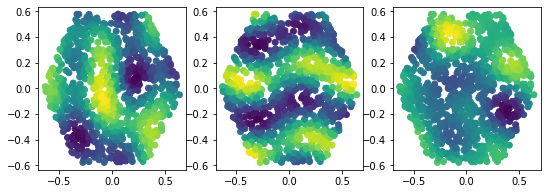

In [9]:
fig,axs = plt.subplots(ncols=3,figsize=(9,3))
axs[0].scatter(*rs.T,c=metric_tensor[...,0,0].detach())
axs[1].scatter(*rs.T,c=metric_tensor[...,1,1].detach())
axs[2].scatter(*rs.T,c=metric_tensor[...,1,0].detach())
#plt.colorbar()

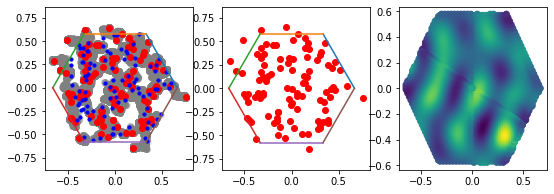

In [10]:
N = len(phases_history)
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
[axs[0].scatter(*phases_history[i].T, c='grey',alpha=(i+0.2)/(N+0.2)) for i in range(0,N,10)]
axs[0].scatter(*phases_history[-1].T, c='red')
axs[0].scatter(*start_phases.T,s=10,c='blue')
axs[0].axis('equal')
model.unit_cell.plot(fig,axs[0])
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))
axs[1].scatter(*phases_history[-1].T, c='red')
axs[1].axis('equal')
model.unit_cell.plot(fig,axs[1])
kde, mesh, _, _ = model.phase_kde(bw_method=0.15)
axs[2].scatter(*mesh.T, c=kde)

In [11]:
torch.save(model,f'./saved-models/{type(model).__name__}-{model.ncells}-dirac')
f'./saved-models/{type(model).__name__}-{model.ncells}-dirac'

'./saved-models/RobustSimilitude-100-dirac'